In [6]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg', 'png')
import matplotlib.pyplot as plt
import pickle
import plotly as py
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
pio.templates.default = "plotly_dark"


import torch
import os
import numpy as np
from sklearn.metrics import roc_curve, det_curve, auc, DetCurveDisplay, RocCurveDisplay
import scipy as sp
import matplotlib.ticker as mtick
import wandb

cm_to_inch = 1.0/2.54

In [25]:
quality_path = os.path.join("..","evaluation","iresnet50_serfiq3.pth")
quality = torch.load(quality_path,map_location=torch.device('cpu') )

In [42]:
rs = ["iresnet50-ArcFaceLoss-1646900877",  "iresnet50-CosFaceLoss-1646929164",
"iresnet50-ArcFaceLoss-1646916504",  "iresnet50-MagFaceLoss-1647016521"]
figures = [None, None, None, None]

In [55]:
for i in range(len(rs)):
    run_name=rs[i]
    scores_path = os.path.join("..","evaluations",f"scores-{run_name}.pickle")
    with open(scores_path, "rb") as f:
        scores = pickle.load( f )
        sorted_y_score = -np.array(scores["pairs"]["cosine"] + scores["impostors"]["cosine"])
        sorted_y_true = np.zeros( len(sorted_y_score) )
        sorted_y_true[:len(scores["pairs"]["cosine"])] = 1
        fmr, fnmr, score_sorted = det(sorted_y_true, sorted_y_score)
        eer = fmr[np.abs(fnmr - fmr).argmin()]
        print(f"EER {run_name}    {eer}")
        figures[i] = get_recognition_performance_fig(fmr, fnmr, None,sorted_y_true, sorted_y_score)

EER iresnet50-ArcFaceLoss-1646900877    0.010408286403861626
EER iresnet50-CosFaceLoss-1646929164    0.021394810941271117
EER iresnet50-ArcFaceLoss-1646916504    0.010785398230088495
EER iresnet50-MagFaceLoss-1647016521    0.010257441673370877


In [56]:
for i, f in enumerate(figures):
    f.update_layout(title=rs[i])
    f.show()

In [5]:
def det(label, score, count=100):
    """
    Get det curve
    """
    g = np.sum(label)
    i = np.sum(1 - label)
    index_list = np.argsort(score)
    label_sorted = label[index_list]
    score_sorted = score[index_list]
    graph = np.zeros((3,count+1))
    for k, j in enumerate(range(0, len(score), len(score)//count)):
        i_count = np.sum(1 - label_sorted[j:])
        g_count = np.sum(label_sorted[:j])
        fmr = i_count / i
        fnmr = g_count / g        
        graph[:,k] = (fmr, fnmr, score_sorted[j])
    return graph[0,:], graph[1,:], graph[2,:]
def get_label_score(I:dict, G:dict, Q:dict):
    all_pairs = [i for i in I] + [g for g in G]
    quality  = [min(Q[x[0]], Q[x[1]]) for x in all_pairs]
    label    = [0 for _ in I] + [1 for _ in G]
    score    = [I[impostor] for impostor in I] + [G[geniune] for geniune in G]
    return np.array(quality), np.array(label), np.array(score), np.array(all_pairs)
def get_label_score_sorted_by_quality(I:dict, G:dict, Q:dict):
    quality, label, score, pairs = get_label_score(I, G, Q)
    index_list = np.argsort(quality)
    return quality[index_list], label[index_list], score[index_list], pairs[index_list,:]
def get_det_for_reject_rates(sorted_y_true, sorted_y_score, reject_rates):
    assert len(sorted_y_true) == len(sorted_y_score)
    for rejection_rate in reject_rates:
        idx = int(len(sorted_y_true)*rejection_rate)
        yield rejection_rate, det_curve(sorted_y_true[idx:], sorted_y_score[idx:])
def get_fnmr_at_irr_new(
    sorted_y_true, sorted_y_score,
    max_reject_rate = 0.15,
    number_of_samples = 100,
    fmr_anchor = 0.01
):
    assert len(sorted_y_true) == len(sorted_y_score)
    graph = []
    rejection_rates = np.arange(0, max_reject_rate, max_reject_rate/number_of_samples)
    for irr, (fmr, fnmr, _) in get_det_for_reject_rates(sorted_y_true, sorted_y_score, rejection_rates):
        anchor_index = np.argmin(np.abs(np.array(fmr) - fmr_anchor))
        graph.append((irr, fnmr[anchor_index]))
    return tuple(zip(*graph))
def plot_dets(dets: dict, ax):
    for det in dets:
        x = np.array(sp.stats.norm.ppf(dets[det][0]))
        y = np.array(sp.stats.norm.ppf(dets[det][1]))
        ax.plot(x, y, label=f"Rejection Rate {det:.0%}")
        ticks = [0.004,0.01, 0.023, 0.05, 0.1, 0.20, 0.5, 0.80, 0.95, 0.99, 0.999]
        tick_locations = sp.stats.norm.ppf(ticks)
        tick_labels = [
            "{:.0%}".format(s) if (100 * s).is_integer() else "{:.1%}".format(s)
            for s in ticks
        ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(tick_labels)
        ax.set_xlim(-3, -1.5)
        ax.set_yticks(tick_locations)
        ax.set_yticklabels(tick_labels)
        ax.set_ylim(-3, -1)
        

In [88]:
Q = np.array([scores_path['scores'][i] for i in quality['scores']])
A = np.argsort(Q)
Q = Q[A]
I = np.array([i for i in quality['scores']])[A]
print("worst 2")
for i in range(2):
    print(I[i], Q[i])
print("best 2")
for i in range(1,3):
    print(I[-i], Q[-i])

worst 2
19731 0.1340993046760559
7192 0.20771704614162445
best 2
26156 0.9995680451393127
1549 0.9994182586669922


In [ ]:
sorted_quality, sorted_y_true, sorted_y_score, pairs = get_label_score_sorted_by_quality(
    scores['impostors']['cosine'], 
    scores['pairs']['cosine'], 
    quality['scores']
)

In [94]:
genuine_pairs = pairs[sorted_y_true == 1, :]

In [100]:
pick = np.logical_or(genuine_pairs[:, 1] == 24823, genuine_pairs[:, 0] == 24823)

#print(genuine_pairs[0])
#print(genuine_pairs[-1])
print(quality['scores'][15300], quality['scores'][10957], quality['scores'][24823])
genuine_pairs[pick, :]

0.9990519881248474 0.990403413772583 0.4990430474281311


array([[10957, 24823],
       [24823, 37459]])

In [63]:
irr, fmr = get_fnmr_at_irr_new(sorted_y_true, sorted_y_score,fmr_anchor=0.01, max_reject_rate=0.2,number_of_samples=50)
dets = dict(get_det_for_reject_rates(sorted_y_true, sorted_y_score, [0, 0.05, 0.15]))

In [18]:
def get_recognition_performance_fig(fmr, fnmr, treashold, y_true, y_score):
    fig = make_subplots(rows=1, cols=3)
    fig.add_trace(go.Scatter(name=f"DET", x = sp.stats.norm.ppf(fmr),y = sp.stats.norm.ppf(fnmr)), row=1, col=1)
    ticks = [0.004,0.01, 0.023, 0.05, 0.1, 0.20, 0.5, 0.80, 0.95, 0.99, 0.999]
    tick_vals = sp.stats.norm.ppf(ticks)
    tick_labels = [
            "{:.0%}".format(s) if (100 * s).is_integer() else "{:.1%}".format(s)
            for s in ticks
        ]
    fig.update_xaxes(
        tickmode = 'array',
        tickvals = tick_vals,
        ticktext = tick_labels,
        row=1, col=1
    )
    fig.update_yaxes(
        tickmode = 'array',
        tickvals = tick_vals,
        ticktext = tick_labels,
        row=1, col=1
    )
    fig.add_trace(go.Histogram(name=f"Genuine", x=y_score[y_true == 1], histnorm='probability',opacity=0.5,nbinsx=20), row=1, col=2)
    fig.add_trace(go.Histogram(name=f"Impostor", x=y_score[y_true == 0], histnorm='probability',opacity=0.5,nbinsx=20), row=1, col=2)
    fig.update_layout(barmode='overlay')
    fig.add_trace(go.Scatter(name=f"FMR", y=fmr, x=treashold), row=1, col=3)
    fig.add_trace(go.Scatter(name=f"FNMR", y=fnmr, x=treashold), row=1, col=3)
    return fig
def get_quality_performance_fig(irr, fmr,dets):
    fig = make_subplots(rows=1, cols=2)
    for d in dets:
        fig.add_trace(go.Scatter(name=f"Rejection rate {d:.0%}", x = sp.stats.norm.ppf(dets[d][0]),y = sp.stats.norm.ppf(dets[d][1])), row=1, col=2)
    
    ticks = [0.004,0.01, 0.023, 0.05, 0.1, 0.20, 0.5, 0.80, 0.95, 0.99, 0.999]
    tick_vals = sp.stats.norm.ppf(ticks)
    tick_labels = [
            "{:.0%}".format(s) if (100 * s).is_integer() else "{:.1%}".format(s)
            for s in ticks
        ]
    fig.update_xaxes(
        tickmode = 'array',
        tickvals = tick_vals,
        ticktext = tick_labels,
        row=1, col=2
    )
    fig.update_yaxes(
        tickmode = 'array',
        tickvals = tick_vals,
        ticktext = tick_labels,
        row=1, col=2
    )
    fig.add_trace(go.Scatter(name=f"False match rate {0.01:.0%}",x=irr, y=fmr),row=1, col=1)
    return fig
#fig = get_quality_performance_fig(irr, fmr, dets)
#fig.show()



In [33]:
fig = get_recognition_performance_fig(fmr, fnmr, None,sorted_y_true, sorted_y_score)
fig.show()

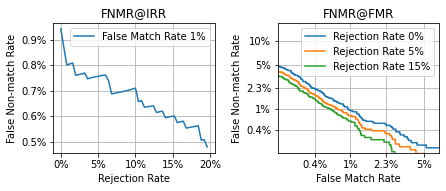

In [16]:
fig, [ax_irr, ax_det] = plt.subplots(1, 2, figsize=(16*cm_to_inch, 7*cm_to_inch))

#fig_irr, ax_irr = plt.subplots(1, 1, figsize=(8*cm_to_inch, 7*cm_to_inch))
ax_irr.plot(irr, fmr, label=f"False Match Rate {0.01:.0%}")
ax_irr.grid()
ax_irr.set_ylabel("False Non-match Rate")
ax_irr.set_xlabel("Rejection Rate")
ax_irr.xaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
ax_irr.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=1))
ax_irr.set_title("FNMR@IRR")
ax_irr.legend()
plt.tight_layout()

#fig_det, ax_det = plt.subplots(1, 1, figsize=(8*cm_to_inch, 7*cm_to_inch))
plot_dets(dets, ax_det)
ax_det.autoscale(False)
ax_det.set_xlabel("False Match Rate")
ax_det.set_ylabel("False Non-match Rate")
ax_det.legend(loc="upper right")
ax_det.set_title("FNMR@FMR")
ax_det.grid()
plt.tight_layout()

In [336]:
wandb.log({"FNMR@FMR chart": fig_det, "FNMR@IRR chart": fig_irr })

/usr/local/lib/python3.8/dist-packages/plotly/matplotlylib/mpltools.py:460: UserWarning:

'linear' x-axis tick spacing not even, ignoring mpl tick formatting.

/usr/local/lib/python3.8/dist-packages/plotly/matplotlylib/mpltools.py:460: UserWarning:

'linear' y-axis tick spacing not even, ignoring mpl tick formatting.

/usr/local/lib/python3.8/dist-packages/plotly/matplotlylib/renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [125]:
def filter_dict_by_quality(quality_treashold: float, quality_score_dict: dict, input_dict: dict):
    filtered_pairs = filter(lambda x: (quality_score_dict[x[0]] > quality_treashold and quality_score_dict[x[1]] > quality_treashold ), input_dict )
    return dict([(x, input_dict[x]) for x in  filtered_pairs])
def get_roc(impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 1000):
    impostor = np.array([impostor_scores_dict[key] for key in impostor_scores_dict])
    pair = np.array([pair_scores_dict[key] for key in pair_scores_dict])
    min_score = min(impostor.min(), pair.min())
    max_score = min(impostor.max(), pair.max())
    impostor_hist = np.histogram(impostor,25,density=True)
    pair_hist = np.histogram(pair,25,density=True)
    
    t_range = np.arange(min_score, max_score, (max_score - min_score)/number_of_points)
    fmr_fnmr = []
    for t in t_range:
        fmr = np.average(impostor <= t)
        fnmr = np.average(pair >= t)
        fmr_fnmr.append((fmr, fnmr))
    fmr_fnmr = np.array(fmr_fnmr)
    i = (np.abs(fmr_fnmr[:,0] - fmr_fnmr[:,1])).argmin()
    eer = t_range[i]
    return fmr_fnmr, eer, t_range, impostor_hist, pair_hist
def get_roc_at_irr(irr: float, quality_score_sorted: np.array, quality_score_dict: dict, impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 1000):
    t = quality_score_sorted[int(irr*len(quality_score_sorted))]
    filtered_impostor_scores_dict = filter_dict_by_quality(t, quality_score_dict, impostor_scores_dict)
    filtered_pair_scores_dict = filter_dict_by_quality(t, quality_score_dict, pair_scores_dict)
    return get_roc(filtered_impostor_scores_dict, filtered_pair_scores_dict)
def get_fnmr_at_irr(quality_score_dict, impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 100, fmr_value = 0.01):
    quality_score = np.array([quality_score_dict[key] for key in quality_score_dict])
    quality_score_sorted = np.sort(quality_score)
    irr_fnmr = []
    for i in range(number_of_points):
        irr = i/number_of_points
        fmr_fnmr, eer, _ , _ , _ = get_roc_at_irr(irr, quality_score_sorted, quality_score_dict, impostor_scores_dict, pair_scores_dict)
        idx = (np.abs(fmr_fnmr[:,0] - fmr_value)).argmin()
        fnmr = fmr_fnmr[idx,1]
        irr_fnmr.append((irr, fnmr))
    return np.array(irr_fnmr), quality_score_sorted
def plot_performance(fmr_at_fnmr, eer, t_range, impostor_hist, pair_hist, title="Plots"):
    cm_to_inch = 1.0/2.54
    fig = plt.figure(figsize=(30*cm_to_inch, 10*cm_to_inch))
    axs = fig.subplots(1, 3)

    
    axs[0].plot(fmr_at_fnmr[:,0],fmr_at_fnmr[:,1])
    axs[0].grid(alpha=0.8, linestyle='dashdot', lw=1)
    axs[0].set_title("FNMR@FMR")
    axs[0].set_xlabel("FMR")
    axs[0].set_ylabel("FNMR")
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    axs[1].hist(pair_hist[1][:-1], pair_hist[1], weights=pair_hist[0],alpha=0.73,label='Pair distribution')
    axs[1].hist(impostor_hist[1][:-1], impostor_hist[1], weights=impostor_hist[0],alpha=0.73,label='Impostor distribution')
    axs[1].legend()
    axs[1].set_xlabel("Dissimiliarity metric")
    axs[1].set_ylabel("Probability")
    axs[1].set_title("Probability distributions")

    axs[2].plot(t_range, fmr_at_fnmr[:,0], label="FMR")
    axs[2].plot(t_range, fmr_at_fnmr[:,1], label="FNMR")
    axs[2].grid(alpha=0.8, linestyle='dashdot', lw=1)
    axs[2].legend()
    axs[2].set_title("FNMR and FMR curves at given treashold")
    axs[2].set_xlabel("Treashold")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    #fig.suptitle(title,fontsize=16,fontstyle="oblique")
    plt.show()
    print(f"Equal error rate: {eer}, FNMR and fmr value: {fmr_at_fnmr[t_range == eer,0][0]}, FNMR at FMR=0.01: {fmr_at_fnmr[(np.abs(fmr_at_fnmr[:,0] - 0.01)).argmin(),1]}")
def plot_irr_fnmr(irr_fnmr, fmr=0.01):
    plt.plot(irr_fnmr[:,0],irr_fnmr[:,1])
    plt.title(f"FNMR@IRR FMR={fmr}")
    plt.xlabel("IRR")
    plt.ylabel("FNMR")
    plt.grid(alpha=0.8, linestyle='dashdot', lw=1)
    plt.show()

In [43]:
irr_fnmr, quality_score_sorted = get_fnmr_at_irr(quality["scores"], evaluation['impostor_scores']['euclidean'], evaluation['pair_scores']['euclidean'], number_of_points=100, fmr_value=0.01)

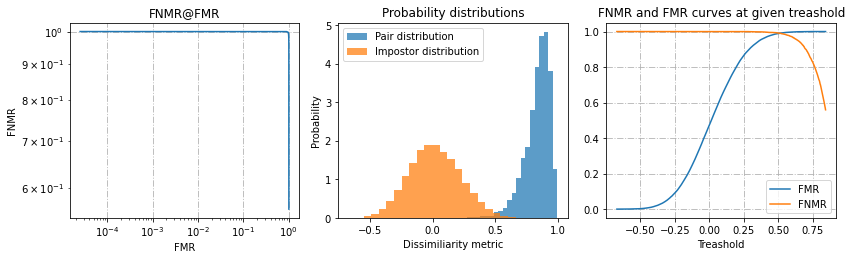

Equal error rate: 0.5111299926638229, FNMR and fmr value: 0.9902956556717619, FNMR at FMR=0.01: 1.0
Done


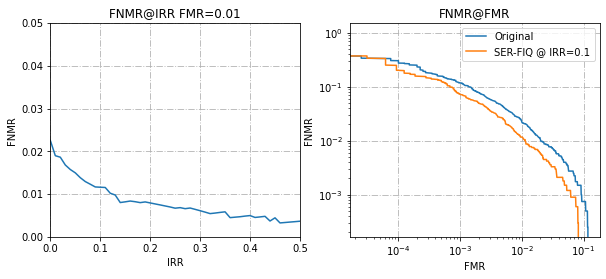

In [107]:
plot_performance(*get_roc(evaluation['impostor_scores']['cosine'], evaluation['pair_scores']['cosine']), title="iResNet50 ArcFace")
#plot_irr_fnmr(irr_fnmr)
#fmn_fnmr_o,_,_,_,_ = get_roc(evaluation['impostor_scores']['euclidean'], evaluation['pair_scores']['euclidean'])
#fmn_fnmr_q,_,_,_,_ = get_roc_at_irr(0.1, quality_score_sorted, quality["scores"], evaluation['impostor_scores']['euclidean'], evaluation['pair_scores']['euclidean'])


cm_to_inch = 1.0/2.54
fig = plt.figure(figsize=(25*cm_to_inch, 10*cm_to_inch))
axs = fig.subplots(1, 2)
axs[0].plot(irr_fnmr[:,0],irr_fnmr[:,1])
axs[0].grid(alpha=0.8, linestyle='dashdot', lw=1)
axs[0].set_title(f"FNMR@IRR FMR={0.01}")
axs[0].set_xlabel("IRR")
axs[0].set_xlim(left=0,right=0.5)
axs[0].set_ylim(bottom=0,top=0.05)
axs[0].set_ylabel("FNMR")

axs[1].plot(fmn_fnmr_o[:,0],fmn_fnmr_o[:,1], label="Original")
axs[1].plot(fmn_fnmr_q[:,0],fmn_fnmr_q[:,1], label=f"SER-FIQ @ IRR={0.1}")
axs[1].legend()
axs[1].grid(alpha=0.8, linestyle='dashdot', lw=1)
axs[1].set_title(f"FNMR@FMR")
axs[1].set_xlabel("FMR")
axs[1].set_ylabel("FNMR")
axs[1].set_xscale('log')
axs[1].set_yscale('log')

print(f"Done")